# Задание 1


Выберите 5 языков в википедии (не тех, что использовались в семинаре). Скачайте по 10 случайных статей для каждого языка. Предобработайте тексты, удаляя лишние теги/отступы/разделители (если они есть). Разделите тексты на предложения и создайте датасет, в котором каждому предложению соответствует язык. Кластеризуйте тексты, используя эбмединг модель из прошлого семинара и любой алгоритм кластеризации. Проверьте качество кластеризации с помощь метрики ARI. Отдельно проанализируйте 3 ошибочно кластеризованных текста (если такие есть).

In [3]:
%pip install wikipedia
import wikipedia
import numpy as np
import pandas as pd
import re

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=6b4fdbcf8ce8d17e90ba27eb8b004c7192feedd4a2f4aca8880582e9fd7e205b
  Stored in directory: /root/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia


In [1]:
def clean_text(text):
    text = re.sub(r'\[[^\]]*\]', '', text)
    text = re.sub(r'\{\{[^\}]*\}\}', '', text)
    text = re.sub(r'==.*?==', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r' +', ' ', text)
    return text.strip()

In [2]:
def load_with_disambigution(page, max_attempts=10):
    try:
        return wikipedia.page(page)
    except wikipedia.DisambiguationError as e:
        for _ in range(max_attempts):
            try:
                option = np.random.choice(e.options)
                return wikipedia.page(option)
            except wikipedia.DisambiguationError:
                continue
            except Exception:
                continue
        return None
    except Exception:
        return None

In [14]:
def get_texts_for_lang(lang, n=10):
    wikipedia.set_lang(lang)
    wiki_content = []

    pages = wikipedia.random(n)

    for page_name in pages:
        try:
            page = load_with_disambigution(page_name)

        except Exception as e:
            print('Skipping page {}'.format(page_name), str(e).strip('\n'))
            continue

        wiki_content.append(page.content)
        if page is None:
            continue

    return wiki_content


In [16]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [22]:
langs = ['ko', 'zh', 'ja', 'no', 'mi']

articles = {}
dataset = []

for lang in langs:
    try:
        articles[lang] = get_texts_for_lang(lang, 10)
    except Exception as e:
        print('ERROR ON - ', lang, str(e).strip('\n'))
        continue

    for article in articles[lang]:
        text = clean_text(article)
        if lang in ['zh', 'ko', 'ja', 'mi']:
            sentences = re.split(r'[.！。？]', text)
        else:
            sentences = sent_tokenize(text)
        for sent in sentences:
            sent = sent.strip()
            if len(sent) > 0:
                dataset.append({"sentence": sent, "language": lang})



In [45]:
df = pd.DataFrame(dataset)
df.to_csv("wiki_sentences.csv", index=False, encoding="utf-8-sig")
for i, row in df.head(50).iterrows():
    print(f"{str(i).ljust(3)} {row['sentence'][:100].ljust(110)} {row['language']}")

0   히데시오역(일본어: 日出塩駅)은 일본 나가노현 시오지리시에 있는 도카이 여객철도 주오 본선의 역이다                                                        ko
1   상대식 승강장 2면 2선을 가지는 지상역                                                                                         ko
2   서로의 승강장은 과선교로 연락하고 있다                                                                                          ko
3   목조의 역사가 남아져 있어, 맞이방의 부분만 이용되고 있다                                                                               ko
4   매표구였던 부분은 널빤지화되고 있다                                                                                            ko
5   기소후쿠시마역 관리의 무인역이다                                                                                              ko
6   모토야마주쿠
나라이 강
국도 제19호선
1일 평균 승차 인원은 이하의 것으로 한다                                                                  ko
7   1999년도 - 36명
2000년도 - 26명
2001년도 - 28명
2002년도 - 30명
2003년도 - 31명
2004년도 - 28명
2005년도 - 25명
2006년도 -            ko
8   1926년 12월 21일 : 히데시오 신호장이 역우로 격상해, 히데시오역으로서 개업      

In [50]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, SpectralClustering
from sklearn.metrics import adjusted_rand_score
from IPython.display import Image
from IPython.core.display import HTML
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [48]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embed = model.encode

df = pd.read_csv('wiki_sentences.csv')
df = df.groupby("language").apply(lambda x: x.sample(100, random_state=42) if len(x) > 100 else x).reset_index(drop=True)
embeddings = model.encode(df["sentence"].tolist(), show_progress_bar=True)

n_clusters = len(df["language"].unique())
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

ari = adjusted_rand_score(df["language"], labels)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/tmp/ipython-input-1749211161.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("language").apply(lambda x: x.sample(100, random_state=42) if len(x) > 100 else x).reset_index(drop=True)


Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Adjusted Rand Index (ARI): 0.681


In [66]:
from collections import Counter
import pandas as pd
import numpy as np

df["cluster"] = labels

cluster_lang_map = (df.groupby("cluster")["language"].agg(lambda x: x.value_counts().index[0]).to_dict())

df["predicted_language"] = df["cluster"].map(cluster_lang_map)

mis = df[df["predicted_language"] != df["language"]]
print(f"Total misclustered sentences: {len(mis)}")

for i, r in mis.sample(3, random_state=42).iterrows():
    print(f"\nSentence #{i}")
    print(f"  {r['sentence'][:200]}...")
    print(f"  True language: {r['language']}")
    print(f"  Predicted:     {r['predicted_language']} (cluster {r['cluster']})")

Total misclustered sentences: 68

Sentence #141
  최치원(崔致遠, 857∼ ?)
신잠(申潛...
  True language: ko
  Predicted:     zh (cluster 4)

Sentence #35
  p...
  True language: ja
  Predicted:     mi (cluster 2)

Sentence #14
  1994年4月23日 - 体育館完成...
  True language: ja
  Predicted:     zh (cluster 4)


Ошибки в кластеризации:


*   в первом предложении используется ханча (по сути китайские иероглифы), поэтому мисмэтч очевиден
*   вторая ошибка возникла, скорее всего, из-за того, что я не учла все варианты при очистке датасета, поэтому такое предложение вообще получилось
*   ошибка в третьем предложении аналогична с первым, тк в японском также используются китайские иероглифы





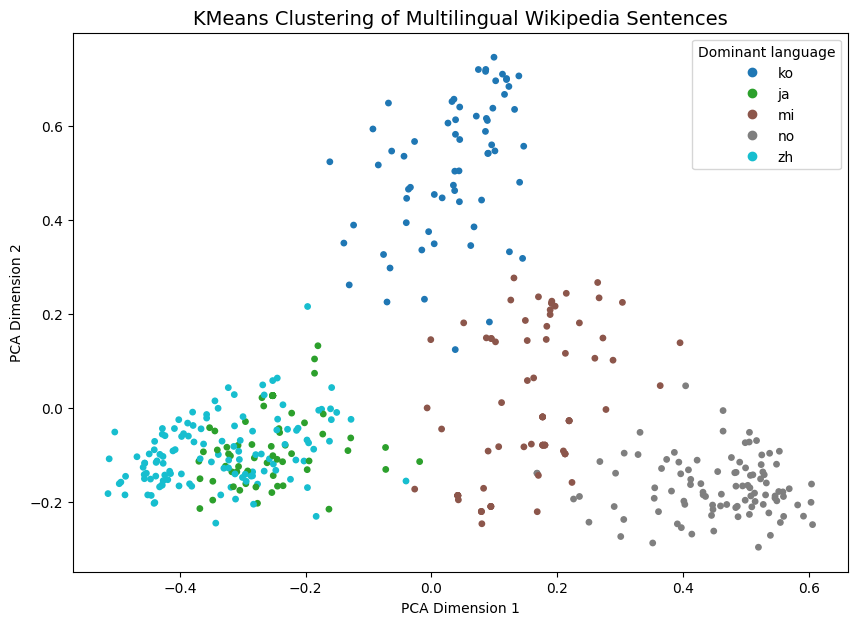

In [67]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

cluster_lang_map = (df.groupby("cluster")["language"].agg(lambda x: x.value_counts().index[0]).to_dict())
plt.figure(figsize=(10,7))
scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', s=15)

unique_clusters = np.unique(labels)
plt.legend(
    handles=scatter.legend_elements()[0],
    labels=[cluster_lang_map[i] for i in unique_clusters],
    title="Dominant language",
    loc="best"
)

plt.title("KMeans Clustering of Multilingual Wikipedia Sentences", fontsize=14)
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

# Задание 2

Загрузите корпус `annot.opcorpora.no_ambig_strict.xml.bz2` с OpenCorpora. Найдите в корпусе самые частотные морфологически омонимичные словоформы (те, которым соответствует разный грамматический разбор в разных предложениях). Также найдите словоформы с самых большим количеством вариантов грамматических разборов.

In [70]:
!wget https://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig_strict.xml.bz2
nltk.download('stopwords')

--2025-10-10 06:15:01--  https://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig_strict.xml.bz2
Resolving opencorpora.org (opencorpora.org)... 172.67.163.210, 104.21.15.199, 2606:4700:3030::6815:fc7, ...
Connecting to opencorpora.org (opencorpora.org)|172.67.163.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1435452 (1.4M) [application/x-bzip2]
Saving to: ‘annot.opcorpora.no_ambig_strict.xml.bz2.1’

annot.opcorpora.no_ 100%[===================>]   1.37M  --.-KB/s    in 0.02s   

2025-10-10 06:15:01 (70.3 MB/s) - ‘annot.opcorpora.no_ambig_strict.xml.bz2.1’ saved [1435452/1435452]



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [72]:
import bz2
from lxml import etree
from nltk.corpus import stopwords
import nltk

with bz2.open('annot.opcorpora.no_ambig_strict.xml.bz2', 'rb') as f_in, open('annot.opcorpora.no_ambig_strict.xml', 'wb') as f_out:
    f_out.write(f_in.read())

open_corpora = etree.fromstring(open('annot.opcorpora.no_ambig_strict.xml', 'rb').read())
stop_words = set(stopwords.words('russian'))

form_to_gramsets = {}
form_freq = {}

for sentence in open_corpora.xpath('//tokens'):
     for token in sentence.xpath('token'):
        word = token.get('text')
        grams = tuple(g.get('v') for g in token.xpath('tfr/v/l/g'))

        if word not in form_to_gramsets:
            form_to_gramsets[word] = set()
        form_to_gramsets[word].add(grams)

        if word not in form_freq:
            form_freq[word] = 0
        form_freq[word] += 1

ambiguous_forms = {}
clean_ambiguous_forms = {}
clean_form_freq = {}
for word, grams in form_to_gramsets.items():
    if len(grams) > 1:
        ambiguous_forms[word] = grams

for word, grams in ambiguous_forms.items():
    if word not in stop_words:
        clean_ambiguous_forms[word] = grams

for word, freq in form_freq.items():
    if word not in stop_words:
        clean_form_freq[word] = freq

ambiguous_forms = clean_ambiguous_forms
form_freq = clean_form_freq

items = list(ambiguous_forms.items())

for i in range(len(items)):
    for j in range(0, len(items)-i-1):
        if form_freq[items[j][0]] < form_freq[items[j+1][0]]:
            items[j], items[j+1] = items[j+1], items[j]

print("Топ-20 частотных омонимов:")
for i in range(min(20, len(items))):
    word = items[i][0]
    grams = items[i][1]
    print(word, form_freq[word], grams)

for i in range(len(items)):
    for j in range(0, len(items)-i-1):
        if len(items[j][1]) < len(items[j+1][1]):
            items[j], items[j+1] = items[j+1], items[j]

print("\nТоп-20 словоформ с наибольшим числом вариантов разборов:")
for i in range(min(20, len(items))):
    word = items[i][0]
    grams = items[i][1]
    print(word, len(grams), grams)


Топ-20 частотных омонимов:
году 115 {('NOUN', 'inan', 'masc', 'sing', 'datv'), ('NOUN', 'inan', 'masc', 'sing', 'loc2')}
России 90 {('NOUN', 'inan', 'femn', 'Sgtm', 'Geox', 'sing', 'datv'), ('NOUN', 'inan', 'femn', 'Sgtm', 'Geox', 'sing', 'loct'), ('NOUN', 'inan', 'femn', 'Sgtm', 'Geox', 'sing', 'gent')}
А 58 {('CONJ',), ('INTJ',)}
которые 53 {('ADJF', 'Apro', 'Subx', 'Anph', 'inan', 'plur', 'accs'), ('ADJF', 'Apro', 'Subx', 'Anph', 'plur', 'nomn')}
О 45 {('PREP',), ('INTJ',)}
человек 45 {('NOUN', 'anim', 'masc', 'sing', 'nomn'), ('NOUN', 'anim', 'masc', 'plur', 'gent')}
США 44 {('NOUN', 'inan', 'GNdr', 'Pltm', 'Fixd', 'Abbr', 'Geox', 'plur', 'nomn'), ('NOUN', 'inan', 'GNdr', 'Pltm', 'Fixd', 'Abbr', 'Geox', 'plur', 'datv'), ('NOUN', 'inan', 'GNdr', 'Pltm', 'Fixd', 'Abbr', 'Geox', 'plur', 'gent'), ('NOUN', 'inan', 'GNdr', 'Pltm', 'Fixd', 'Abbr', 'Geox', 'plur', 'accs'), ('NOUN', 'inan', 'GNdr', 'Pltm', 'Fixd', 'Abbr', 'Geox', 'plur', 'ablt'), ('NOUN', 'inan', 'GNdr', 'Pltm', 'Fixd', 'Ab

## Задание 3
Загрузите один и з файлов корпуса Syntagrus - https://github.com/UniversalDependencies/UD_Russian-SynTagRus/tree/master (можно взять тестовый)

Преобразуйте все разборы предложений в графовые структуры через DependencyGraph, выберите 3 любых отношения и для каждого найдите топ-5 самых встречаемых пар слов, связанных этим отношением.

Для самой частотной пары слов в каждом из отношений вытащите все подзависимые слова для каждого из них во всех предложениях (используя `flatten(get_subtree(d.nodes, index_of_a_word)` и сортируя результат по порядку слов в предложениях, аналогично тому как я делал с summaries только у вас будет два слова)
В итоге у вас должен получится что-то такое:

```
### отношение
relation_name

### топ 5 пар слов связанных этим отношением
(word1, word2), (word3, word4), (word5, word6), (word7, word8), (word9, word10)

### подзависимые для самого частотного
(subword word1 subword, word2 subword subword)

... (и так три раза)
```


I'm so sorry, но до синтагруза не успела ☹